In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging


D:\anaconda python\lib\site-packages\qiskit\optimization\__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [2]:


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


distance
 [[0. 4. 5.]
 [4. 0. 3.]
 [5. 3. 0.]]


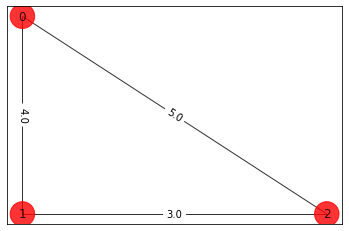

In [3]:
import itertools
import math
n= 3
num_qubits = n ** 2

tempcoord=np.array([[0,4],[0,0],[3,0]])
# ,[7,8],[5,5]
tempw = np.zeros((n, n))


for i in range(n):
    for j in range(n):
        temp= tempcoord[i]-tempcoord[j]
        tempw[i,j]=np.round_((math.hypot(temp[0],temp[1])),2)

ins=tsp.TspData(name=0,dim=n,coord=tempcoord,w=tempw)

# ins = tsp.random_tsp(n, seed=123)
print('distance\n', ins.w)


# Draw the graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, ins.dim, 1))
colors = ['r' for node in G.nodes()]

for i in range(0, ins.dim):
    for j in range(i+1, ins.dim):
        G.add_edge(i, j, weight=ins.w[i,j])

pos = {k: v for k, v in enumerate(ins.coord)}

draw_graph(G, colors, pos)

[(1, 2), (2, 1)]
order = (0, 1, 2) Distance = 12.0
Best order from brute force = (0, 1, 2) with total distance = 12.0


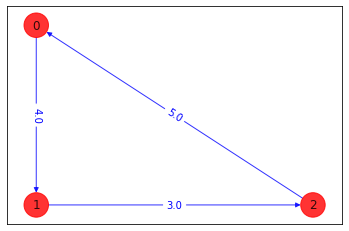

In [4]:
from itertools import permutations
import itertools
def brute_force_tsp(w, N):
    a= list(permutations(range(1,N)))
    print(a)
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order

best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

draw_tsp_solution(G, best_order, colors, pos)

In [5]:
qubitOp, offset = tsp.get_operator(ins)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: 600018.0
Ising Hamiltonian:
IIIIIIIIZ	(-100004.5+0j)
IIIIZIIII	(-100003.5+0j)
IIIIZIIIZ	(1+0j)
IIIIIIIZI	(-100004.5+0j)
IIIZIIIII	(-100003.5+0j)
IIIZIIIZI	(1+0j)
IIIIIIZII	(-100004.5+0j)
IIIIIZIII	(-100003.5+0j)
IIIIIZZII	(1+0j)
IZIIIIIII	(-100004+0j)
IZIIIIIIZ	(1.25+0j)
ZIIIIIIII	(-100004+0j)
ZIIIIIIZI	(1.25+0j)
IIZIIIIII	(-100004+0j)
IIZIIIZII	(1.25+0j)
IIIIIZIZI	(1+0j)
IIIIZIZII	(1+0j)
IIIZIIIIZ	(1+0j)
IZIIIZIII	(0.75+0j)
ZIIIZIIII	(0.75+0j)
IIZZIIIII	(0.75+0j)
IIZIIIIZI	(1.25+0j)
IZIIIIZII	(1.25+0j)
ZIIIIIIIZ	(1.25+0j)
IIZIZIIII	(0.75+0j)
IZIZIIIII	(0.75+0j)
ZIIIIZIII	(0.75+0j)
IIIIIZIIZ	(50000+0j)
IIZIIIIIZ	(50000+0j)
IIZIIZIII	(50000+0j)
IIIIZIIZI	(50000+0j)
IZIIIIIZI	(50000+0j)
IZIIZIIII	(50000+0j)
IIIZIIZII	(50000+0j)
ZIIIIIZII	(50000+0j)
ZIIZIIIII	(50000+0j)
IIIIIIIZZ	(50000+0j)
IIIIIIZIZ	(50000+0j)
IIIIIIZZI	(50000+0j)
IIIIZZIII	(50000+0j)
IIIZIZIII	(50000+0j)
IIIZZIIII	(50000+0j)
IZZIIIIII	(50000+0j)
ZIZIIIIII	(50000+0j)
ZZIIIIIII	(50000+0j)



D:\anaconda python\lib\site-packages\qiskit\optimization\applications\ising\tsp.py:207: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), shift


In [6]:
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 200000 x_0 - 200000 x_1 - 200000 x_2 - 200000 x_3 - 200000 x_4 - 200000 x_5
 - 200000 x_6 - 200000 x_7 - 200000 x_8 [ 200000 x_0*x_1 + 200000 x_0*x_2
 + 200000 x_0*x_3 + 4 x_0*x_4 + 4 x_0*x_5 + 200000 x_0*x_6 + 5 x_0*x_7
 + 5 x_0*x_8 + 200000 x_1*x_2 + 4 x_1*x_3 + 200000 x_1*x_4 + 4 x_1*x_5
 + 5 x_1*x_6 + 200000 x_1*x_7 + 5 x_1*x_8 + 4 x_2*x_3 + 4 x_2*x_4
 + 200000 x_2*x_5 + 5 x_2*x_6 + 5 x_2*x_7 + 200000 x_2*x_8 + 200000 x_3*x_4
 + 200000 x_3*x_5 + 200000 x_3*x_6 + 3 x_3*x_7 + 3 x_3*x_8 + 200000 x_4*x_5
 + 3 x_4*x_6 + 200000 x_4*x_7 + 3 x_4*x_8 + 3 x_5*x_6 + 3 x_5*x_7
 + 200000 x_5*x_8 + 200000 x_6*x_7 + 200000 x_6*x_8 + 200000 x_7*x_8 ] +
 600000;
 
subject to {

}


In [7]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: 12.0
optimal value: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
status: SUCCESS


D:\anaconda python\lib\site-packages\qiskit\aqua\algorithms\minimum_eigen_solvers\minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
D:\anaconda python\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


energy: -600006.0
tsp objective: 12.0
feasible: True
solution: [1, 2, 0]
solution objective: 12.0


D:\anaconda python\lib\site-packages\qiskit\aqua\operators\state_fns\vector_state_fn.py:215: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  unique, counts = np.unique(aqua_globals.random.choice(list(deterministic_counts.keys()),


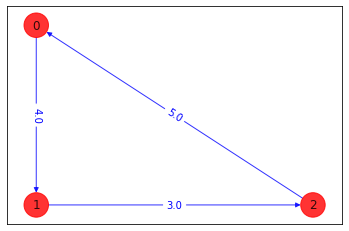

In [8]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

In [42]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [43]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

result = vqe.run(quantum_instance)

print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536) and data type complex128